# Introduction

## About

Image classifier that recognizes different Brazilian Jiu Jitsu grappling positions and predicts future outcomes! Uses a sequential neural network trained on a dataset of mounts/guards/submissions/areas of control to label the most resembled situation and a decision tree map to return the k-closest neighbours

## Editorial

```
V1: Multi-class image classifier (armbar, arm triangle, double-leg, guillotine, koshi guruma, leg triangle, rnc)

    Notes:
    - Best result: 96% training acc, 65% validation acc
    - Need to: optimize regularization techniques to work effectively (not underfit)
    - May need more data and a more complex model
```

## Flow Chart

This flow chart/decision tree maps different submissions/escapes/passes and takedowns according to the starting position. The highlighted colours give a rough idea of the quality of respective data per query on ~100 google images.

```
Dark grey: very poor,
Grey: poor,
Light grey: average,
Green: good,
Blue: very good
```

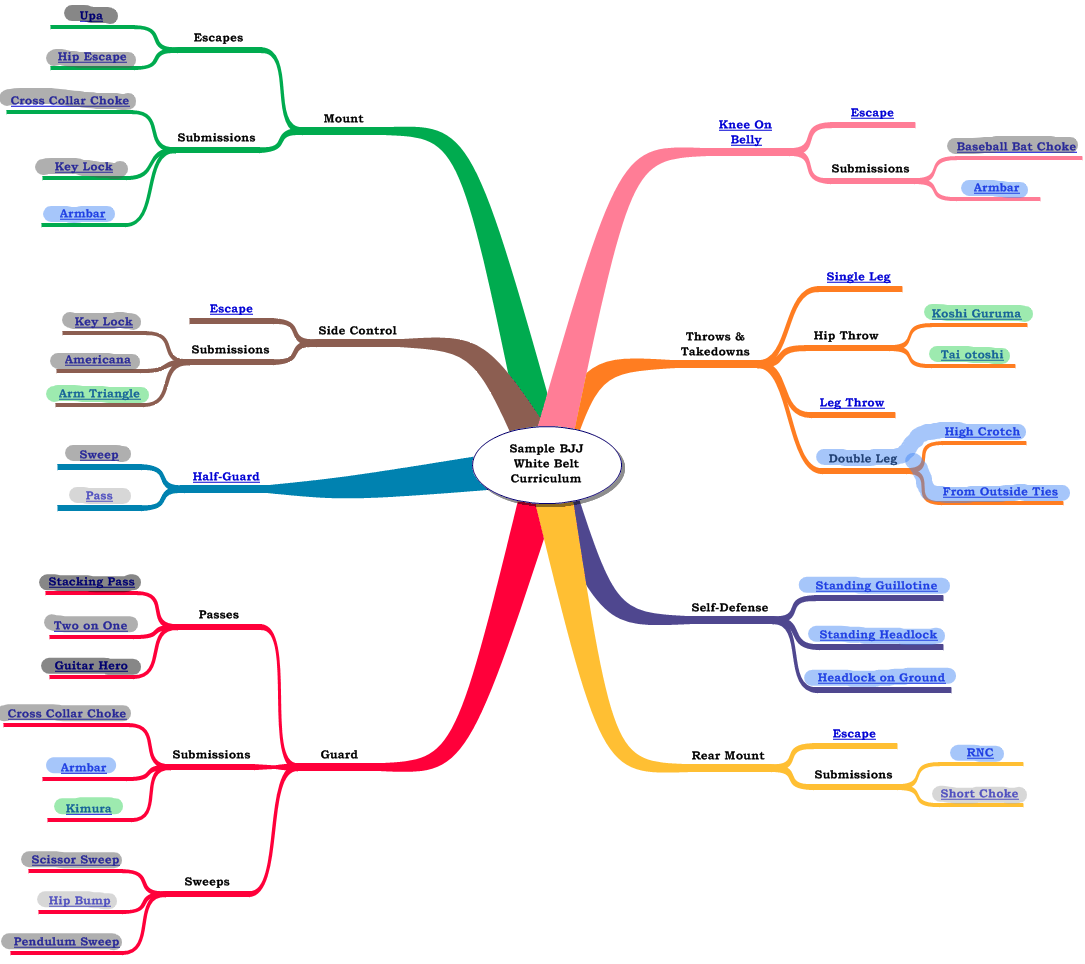

## 1. Dependencies

In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip install keras

In [ ]:
!pip list

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import to_categorical
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

## 2. Configure Setup

In [4]:
# # *** This only works natively with NVIDIA gpus
# Avoid Out of Memory errors by enabling VRAM consumption growth
# gpu = tf.config.experimental.list_physical_devices('gpu')
# tf.config.experimental.set_memory_growth(gpu, True)

## 3. Import Data

#### Remove unwanted images

In [5]:
data_dir = "../JiuJitsuAI/Data"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

#### Display a mock batch of images

In [58]:
images = tf.keras.utils.image_dataset_from_directory('../JiuJitsuAI/Data')

Found 1444 files belonging to 7 classes.


In [59]:
image_iterator = images.as_numpy_iterator()

In [60]:
batch = image_iterator.next()

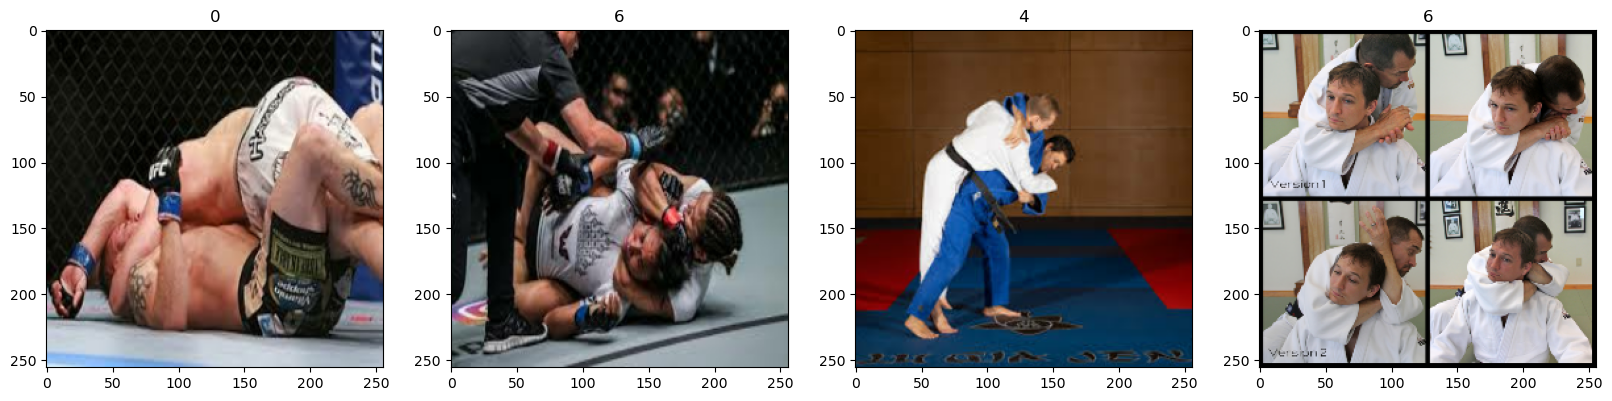

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int), cmap='gray', vmin=0, vmax=1)
  ax[idx].title.set_text(batch[1][idx])

## 4. Preprocess Data

In [62]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset='training'
)
data = data.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 1011 files for training.


In [63]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
val = val.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 288 files for validation.


In [66]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
test = test.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 144 files for validation.


## 5. Build Model

In [87]:
model = Sequential()

In [88]:
from tensorflow.keras.regularizers import l2

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(7, activation='softmax'))

In [89]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)       

## 6. Train Model

In [91]:
logdir = '../JiuJitsuAI/Logs'

In [92]:
#Log out model training as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [93]:
#Data, how long you will train for, after all training batches are run validation data is used, additional callbacks
history = model.fit(
    data,
    epochs=10,
    validation_data=val_data,
    callbacks=[tensorboard_callback]
)

Epoch 1/12
32/32 [==============================] - 42s 1s/step - loss: 2.5414 - accuracy: 0.1642 - val_loss: 1.0945 - val_accuracy: 0.2014
Epoch 2/12
32/32 [==============================] - 38s 1s/step - loss: 0.8180 - accuracy: 0.1978 - val_loss: 0.7396 - val_accuracy: 0.2326
Epoch 3/12
32/32 [==============================] - 37s 1s/step - loss: 0.6454 - accuracy: 0.2324 - val_loss: 0.6321 - val_accuracy: 0.2917
Epoch 4/12
32/32 [==============================] - 38s 1s/step - loss: 0.5799 - accuracy: 0.2710 - val_loss: 0.5707 - val_accuracy: 0.2847
Epoch 5/12
32/32 [==============================] - 39s 1s/step - loss: 0.5488 - accuracy: 0.2601 - val_loss: 0.5506 - val_accuracy: 0.2674
Epoch 6/12
32/32 [==============================] - 39s 1s/step - loss: 0.5168 - accuracy: 0.2888 - val_loss: 0.5179 - val_accuracy: 0.2882
Epoch 7/12
32/32 [==============================] - 37s 1s/step - loss: 0.4956 - accuracy: 0.3037 - val_loss: 0.4916 - val_accuracy: 0.3021
Epoch 8/12
32/32 [==